# HMC gradient model

Conceptual setup of Hamiltonian Monte Carlo with a derivGP as a surrogate for gradients.
The notebook contains

1. A test function (Banana embedded in some higher dimension)
2. run actual HMC
3. a simple training procedure for a surrogate 
4. compare 

In [4]:
import numpy as np
import scipy.linalg as slinalg

import matplotlib.pyplot as plt
from hamiltonian_mc import HamiltonianMonteCarlo, GPGradientHMC

import sys
sys.path.append('../')

from test_functions.banana import Banana

In [5]:
dim = 100

## 1. Banana function

$$ f(x_1, x_2) = \exp \left(- \frac{1}{2} \left(x_1^2 + (a_1 x_1^2 + a_2 x_2 + a_3)^2 \right)\right) $$

In [6]:
a = np.ones((dim+1)) * 2.
a[2] = -a[2]

f = Banana(dim, a)

def E(x):
    return f.pot_energy(x)

def grad_E(x):
    return f.grad_e(x)

def fun(x):
    return f.f(x)

# aa = [2., 2., -2., 2]
# 
# def x_trafo(x):
#     xnew = x.copy()
#     if xnew.ndim == 1:
#         xnew = xnew[:, None]
#     xnew[1,:] = aa[0]*xnew[0,:]**2 + aa[1]*xnew[1,:] + aa[2]
#     xnew[2:,:] = aa[-1]*xnew[2:,:]
#     return xnew

# def fun(x):
#     "Some unnormalized density"
#     arg = x_trafo(x)
#     return np.exp(-E(x)).squeeze()

# def E(x):
#     "The negative log of the above, that is, the potential energy"
#     arg = x_trafo(x)
#     return 0.5*(arg**2).sum(axis=0).squeeze()

# def grad_E(x):
#     grad = x_trafo(x)
#     grad[0, :] = grad[0, :] + grad[1, :] * 2 * x[0, :] * aa[0]
#     grad[1, :] = grad[1, :] * aa[1]
#     return grad

# TODO: Rotate the problem to get misalignment with kernel
# TODO: Repeat for many seeds

In [7]:
# compute true mean value
from scipy.integrate import dblquad

def mean2d_1(x1, x2):
    x = np.asarray([x1, x2])
    return x1*fun(x)

def mean2d_2(x1, x2):
    x = np.asarray([x1, x2])
    return x2*fun(x)

def true_mean():
    mean = np.zeros((dim,))
    mean[0] = dblquad(mean2d_1, -10, 10, -10, 10)
    mean[1] = dblquad(mean2d_2, -10, 10, -10, 10)
    return mean

In [8]:
np.random.seed(10)
x0 = np.random.randn(dim, 1)

sqrt4_d = np.ceil(dim**0.25)

T = int(12 * sqrt4_d)
h = 1.e-2 / sqrt4_d

N_burn = dim

## 2. Plain HMC

In [9]:
hmc = HamiltonianMonteCarlo(E, grad_E, T, h, N_burn=N_burn)
X_hmc = hmc.sample(5000, x0)

In [10]:
hmc.diagnostics.acceptance_rate, hmc.diagnostics.probability_accept

(0.5445098039215663, 0.5527114656052531)

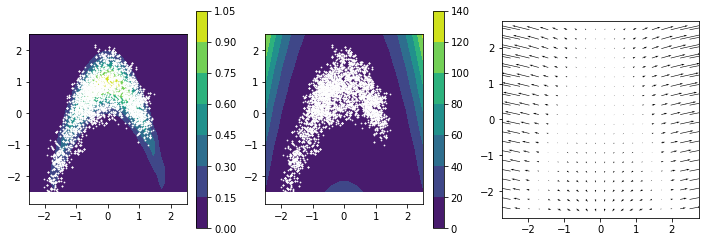

In [12]:
# plt.style.use("icml21.mplstyle")
N_plot = 20

x_plot = np.linspace(-2.5,2.5,N_plot)
X1, X2 = np.meshgrid(x_plot, x_plot, indexing='ij')
X = (np.stack([X1, X2], axis=0)).reshape(2, -1)

X_dim = np.zeros((dim, X.shape[1])); X_dim[:2,:] = X

fig, ax = plt.subplots(1, 3, figsize=(12,4))
functions = [fun, E]
for i in range(2):
    cpl = ax[i].contourf(X1, X2, functions[i](X_dim).reshape(N_plot, N_plot), cmap='viridis')
    ax[i].set_aspect('equal')
#     ax[i].scatter(x0[0], x0[1], c='red', s=2.)
    ax[i].scatter(X_hmc[:,0], X_hmc[:,1], c='w', s=0.5)
    plt.colorbar(cpl, ax=ax[i])

gradE = grad_E(X_dim)
ax[2].quiver(X1, X2, gradE[0,:].reshape(N_plot, N_plot), gradE[1,:].reshape(N_plot, N_plot), scale=1.e3)
ax[2].set_aspect('equal')

In [ ]:
from scipy.stats import norm

fig, ax = plt.subplots(1, 2, figsize=(12,4))

E_hmc = E(X_hmc.T)
bin_list = np.linspace(min(E_hmc - np.mean(E_hmc)), max(E_hmc - np.mean(E_hmc)), 50)
xx = np.linspace(-2,2,120)
ax[0].hist(E_hmc[1:] - E_hmc[:-1], bins=bin_list, density=False, alpha=0.7, label='dE')
Ehist = ax[0].hist(E_hmc - np.mean(E_hmc), bins=bin_list, density=False, alpha=0.7, label='E')
ax[0].legend()
ax[1].hist(E_hmc[1:] - E_hmc[:-1], bins=50, density=False, alpha=0.7, label='dE')
ax[1].hist(np.asarray(hmc.diagnostics.info['dH']).squeeze(), bins=50, density=False, alpha=0.7, label='dH')
ax[1].legend()
plt.show()

In [10]:
E_BFMI = ((E_hmc[1:] - E_hmc[:-1])**2).sum() / ((E_hmc - np.mean(E_hmc))**2).sum()
E_BFMI

0.04231748761506315

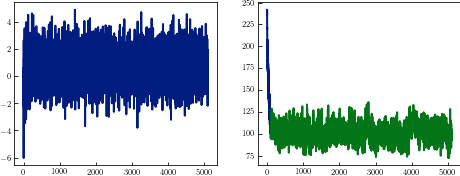

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(8,3))
ax[0].plot(hmc.diagnostics.info['dH'])
ax[1].plot(np.arange(0, N_burn), hmc.diagnostics.info['H'][:N_burn])
ax[1].plot(np.arange(N_burn, 5000+N_burn), hmc.diagnostics.info['H'][N_burn:5000+N_burn])

**Why is the normal distribution over energy values shifted in the first place?** --> check if this is a mistake.

In [112]:
def effective_n(chain):
    """
    Calculate the effective sample size of a Markov chain.
    """
    maxlag = 200
    n = chain.shape[0]
    rho = np.zeros(maxlag)
    for i in range(maxlag):
        if i%10 == 0:
            print('step ', i)
        t = i + 1
        acf = np.corrcoef(chain[t:, :], chain[:(n - t), :])[0, 1]
        if acf < 0:
            break
        rho[i] = acf
    return(n / (1 + np.sum(rho)))

In [13]:
effective_n(X_hmc)

step  0


KeyboardInterrupt: 

## 3. Hamiltonian Monte Carlo with gradient surrogate

Collect $\sqrt{D}$ GP samples, so effective scaling is $D^3$

In [12]:
import sys

sys.path.append('../src')
from inference import DerivativeGaussianProcess
from kernels import RBF, ExponentialKernel, LinearKernel

In [13]:
kern = RBF(dim, 2.5/dim)
gp = DerivativeGaussianProcess(kern)
# dX_2d = np.asarray([[0, 1], [-1, 0], [1, 0], [-2, -2], [2, -2], [0, 1], [-1, 0], [1, 0], [-2, -2], [2, -2]]).T



In [14]:
# dX = np.zeros((dim, 10))
# dX[:2, :] = dX_2d +  np.random.randn(2, 10)*0.3

# gp.condition(dX=dX, dY=grad_E(dX))

gpg_hmc = GPGradientHMC(E, grad_E, gp, T, h, N_train=int(np.sqrt(dim)), N_burn=N_burn)

Sample from objective, including training

In [32]:
np.random.seed(10) # fix same random sequence as above
x0 = np.random.randn(dim, 1)

X_gph = gpg_hmc.sample(5000, x0)

In [33]:
gpg_hmc.gp_trainer.N_dat

10

In [34]:
Kpp = kern._d2K_dr2(gp.data['dX'], gp.data['dX'])
assert 0. not in 1./Kpp

In [35]:
gpg_hmc.diagnostics.acceptance_rate, gpg_hmc.diagnostics.probability_accept

(0.4634313725490162, 0.4651827156240262)

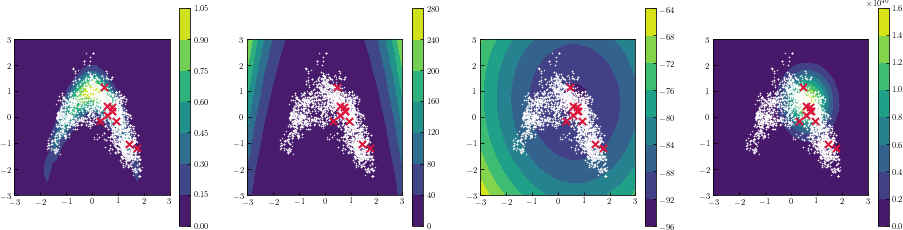

In [36]:
N_plot = 20

x_plot = np.linspace(-3.,3.,N_plot)
X1, X2 = np.meshgrid(x_plot, x_plot, indexing='ij')
X = (np.stack([X1, X2], axis=0)).reshape(2, -1)

X_dim = np.zeros((dim, X.shape[1])); X_dim[:2,:] = X


fig, ax = plt.subplots(1, 4, figsize=(16,4))

# def exp_infer_f(x):
#     return np.exp(-gp.infer_f(x))

functions = [fun, E, gp.infer_f, lambda x: np.exp(-gp.infer_f(x))]
for i in range(4):
    cpl = ax[i].contourf(X1, X2, functions[i](X_dim).reshape(N_plot, N_plot), cmap='viridis')
    ax[i].set_aspect('equal')
#     ax[i].scatter(x0[0], x0[1], c='y', s=50, marker='x')
    ax[i].scatter(X_gph[:, 0], X_gph[:, 1], c='w', s=0.2)
    ax[i].scatter(gp.data['dX'][0, :], gp.data['dX'][1, :], c='crimson', s=50, marker='x')
    plt.colorbar(cpl, ax=ax[i])

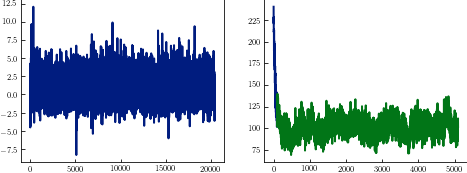

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(8,3))
ax[0].plot(gpg_hmc.diagnostics.info['dH'])
ax[1].plot(np.arange(0, N_burn), gpg_hmc.diagnostics.info['H'][:N_burn])
ax[1].plot(np.arange(N_burn, 5000+N_burn), gpg_hmc.diagnostics.info['H'][N_burn:5000+N_burn])

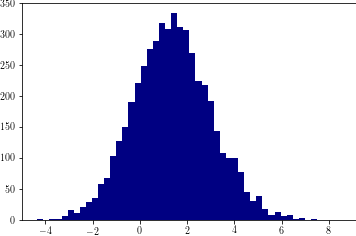

In [30]:
plt.hist(np.asarray(gpg_hmc.diagnostics.info['dH']).squeeze(), bins=50)

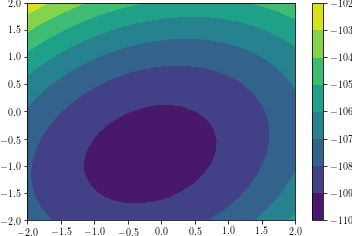

In [31]:
N_plot = 20

x_plot = np.linspace(-2.,2.,N_plot)
X1, X2 = np.meshgrid(x_plot, x_plot, indexing='ij')
X = (np.stack([X1, X2], axis=0)).reshape(2, -1)

X_dim = np.zeros((dim, X.shape[1])); X_dim[:2,:] = X

cpl = plt.contourf(X1, X2, gp.infer_f(X_dim).reshape(N_plot, N_plot), cmap='viridis')
plt.colorbar(cpl)

In [109]:
from scipy.stats import special_ortho_group
import warnings

class Banana:
    def __init__(self, dim, a, seed=None):
        """
        f(x) = \exp (- 0.5*(x_1^2 + (a_0 x_1^2 + a_1 x_2 + a_2)^2 + \sum_{i=3}^D a_i x_i^2 ))
        :param a: parameters of the banana
        """
        if a.size < dim + 1:
            warnings.warn('parameter vector is too short, remaining ones will be filled with 1.')
            a = np.concatenate([a.flatten(), np.ones((dim+1 - a.size))])
        
        self.dim = dim
        self.a = a
        
        # sample a random rotation matrix
        self.R = special_ortho_group(dim, seed).rvs()
        
    def _x_trafo(self, x):
        x = self.R @ x
        if x.ndim == 1:
            x = x[:, None]
        x[1,:] = self.a[0]*x[0,:]**2 + self.a[1]*x[1,:] + self.a[2]
        x[2:,:] = self.a[3:, None]*x[2:,:]
        return x

    def f(self, x):
        "Some unnormalized density"
        arg = self._x_trafo(x)
        return np.exp(-self.E(x)).squeeze()

    def E(self, x):
        "The negative log of the above, that is, the potential energy"
        arg = self._x_trafo(x)
        return 0.5*(arg**2).sum(axis=0).squeeze()

    def grad_E(self, x):
        grad = self._x_trafo(x)
        grad[0, :] = grad[0, :] + grad[1, :] * 2 * x[0, :] * self.a[0]
        grad[1, :] = grad[1, :] * self.a[1]
        return grad

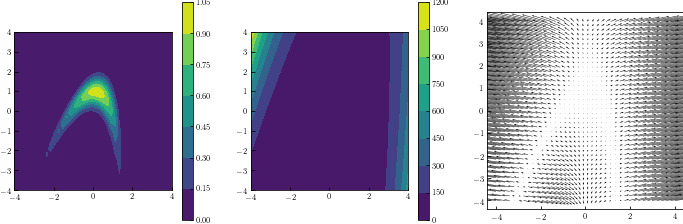

In [110]:
banana = Banana(2, np.asarray([2.,2.,-2.]), seed=100)

N_plot = 40

x_plot = np.linspace(-4,4,N_plot)
X1, X2 = np.meshgrid(x_plot, x_plot, indexing='ij')
X = (np.stack([X1, X2], axis=0)).reshape(2, -1)


fig, ax = plt.subplots(1, 3, figsize=(12,4))
functions = [banana.f, banana.E]
for i in range(2):
    cpl = ax[i].contourf(X1, X2, functions[i](X).reshape(N_plot, N_plot), cmap='viridis')
    ax[i].set_aspect('equal')
    plt.colorbar(cpl, ax=ax[i])

gradE = banana.grad_E(X)
ax[2].quiver(X1, X2, gradE[0,:].reshape(N_plot, N_plot), gradE[1,:].reshape(N_plot, N_plot), scale=1.e3)
ax[2].set_aspect('equal')


In [111]:
banana = Banana(10, np.asarray([2.,2.,-2.]), seed=100)

/home/alex/Tools/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: parameter vector is too short, remaining ones will be filled with 1.
  # This is added back by InteractiveShellApp.init_path()


In [33]:
# quadratic kernel

def kquad(x1, x2):
    return (x1[:, None] * x2[None, ...])**2 + 10*np.exp(-(x1[:, None] - x2[None, ...])**2)

x_plot = np.linspace(-10.,10.,N_plot)
x_train = np.random.randn(2)*4 - 2

# prior samples
K = kquad(x_plot, x_plot)
Lquad = slinalg.cholesky(kquad(x_plot, x_plot) + 1.e-6*np.eye(N_plot), lower=True)

z = Lquad @ np.random.randn(N_plot, 10)
# mean_quad = kquad(x_plot, x_train) * np.linalg.solve(kquad(x_train, x_train), y)

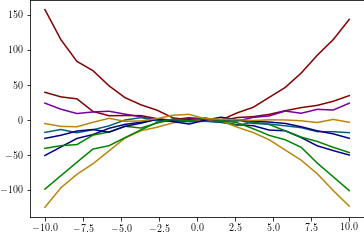

In [34]:
plt.plot(x_plot, z)
plt.show()